In [1]:
def off_diagonal_vec(sop):
    new_mat = []
    for i, row in enumerate(sop):
        for j, col in enumerate(row):
            if i==j:
                continue
            new_mat.append(col)
    return np.array(new_mat)

In [2]:
def sop_to_ptm(sop):
    ret = np.zeros((4,4))
    for i, p in enumerate(ps):
        for j, q in enumerate(ps):
            ret[i][j] = np.trace(p.dot(sop.dot(q.dot(np.conj(sop.T)))))
    return ret

In [3]:
import cvxpy as cp
from scipy.linalg import expm
import numpy as np
from pauli_channel_approximation import off_diagonal_projection

scales = [1.064, 1.039, .937, .912]
x = np.array([[0, 1], [1, 0]])
unitaries = []
ps = [np.eye(2), x, np.array([[0, -1.j], [1.j, 0]]), np.array([[1, 0], [0, -1]])]
pps = [np.kron(p, q) for p in ps for q in ps]
vecs = []
for scale in scales:
    unitary = expm(-1.j * scale * np.pi/2 * x)
    error =  np.conj(unitary.T).dot(x)
    vecs.append(off_diagonal_vec(sop_to_ptm(error)))

/home/apolloreno/anaconda3/envs/estuary/lib/python3.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


In [4]:
omega = cp.Variable(4)
constraints = [0 <= omega, omega <= 1, sum(omega) == 1]
objective_argument = cp.norm(np.matrix(np.vstack(vecs).T) * omega)
objective = cp.Minimize(objective_argument)
prob = cp.Problem(objective, constraints)
_ = prob.solve(solver=cp.MOSEK, verbose=True)
res = omega.value

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 22              
  Cones                  : 1               
  Scalar variables       : 18              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 22              
  Cones               

In [5]:
a = [[0.307 ],[0.283],[0.211],[0.199]]

In [6]:
sum([b[0] for b in a])

1.0

In [7]:
from pauli_channel_approximation import *

In [8]:
res

matrix([[0.3071617 ],
        [0.28249117],
        [0.21143395],
        [0.19891318]])

/home/apolloreno/anaconda3/envs/estuary/lib/python3.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


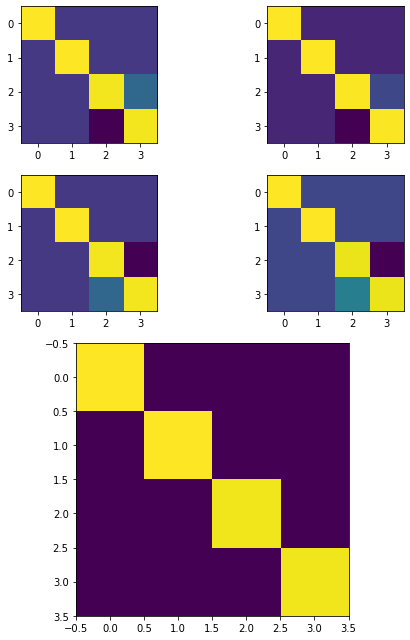

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

sops = []

fig = plt.figure(figsize=(7, 9))
gs = gridspec.GridSpec(nrows=3, ncols=2, height_ratios=[1, 1, 2])

ax0 = fig.add_subplot(gs[0, 0])

ax1 = fig.add_subplot(gs[0, 1])

ax2 = fig.add_subplot(gs[1, 0])

ax3 = fig.add_subplot(gs[1, 1])

ax4 = fig.add_subplot(gs[2:, :])
axes = [ax0,ax1,ax2,ax3]


for i, scale in enumerate(scales):
    unitary = expm(-1.j * scale * np.pi/2 * x)
    error =  np.conj(unitary.T).dot(x)
    #plt.subplot(subplots[i])
    axes[i].imshow(sop_to_ptm(error))
    sops.append(error)
    
avg = np.zeros((4,4))
for i, sop in enumerate(sops):
    avg += res[i].tolist()[0][0] * sop_to_ptm(sop)
ax4.imshow(avg)
    # plt.show()
# plt.imshow(avg)
#plt.tight_layout()

plt.tight_layout()
plt.show()

/home/apolloreno/anaconda3/envs/estuary/lib/python3.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


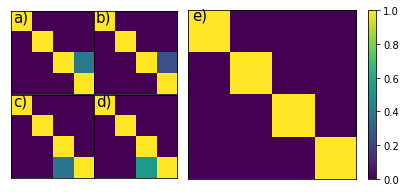

In [295]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

sops = []

fig = plt.figure(figsize=(7,3.1), )
gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[1,1], width_ratios=[1,1,2.69])
gs.update(wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])

ax1 = fig.add_subplot(gs[0, 1])

ax2 = fig.add_subplot(gs[1, 0])

ax3 = fig.add_subplot(gs[1, 1])

ax4 = fig.add_subplot(gs[:, 2:])
axes = [ax0,ax1,ax2,ax3]


for i, scale in enumerate(scales):
    unitary = expm(-1.j * scale * np.pi/2 * x)
    error =  np.conj(unitary.T).dot(x)
    #plt.subplot(subplots[i])
    ax = axes[i]
    ax.imshow(sop_to_ptm(error),vmin=0, vmax=1)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    sops.append(error)
    
def get_axis_limits(ax):
    return ax.get_xlim()[0]+.1, ax.get_ylim()[1]*0
ax0.annotate('a)', xy=get_axis_limits(ax0), c='k',size=15)
ax1.annotate('b)', xy=get_axis_limits(ax1), c='k',size=15)
ax2.annotate('c)', xy=get_axis_limits(ax2), c='k',size=15)
ax3.annotate('d)', xy=get_axis_limits(ax3), c='k',size=15)

ax4.annotate('e)', xy=(ax.get_xlim()[0]+.1, ax.get_ylim()[1]*.55), c='k',size=15)
avg = np.zeros((4,4))
for i, sop in enumerate(sops):
    avg += res[i].tolist()[0][0] * sop_to_ptm(sop)
ax4.imshow(avg, vmin=0, vmax=1)
ax4.get_xaxis().set_ticks([])
ax4.get_yaxis().set_ticks([])
for PCM in ax.get_children():
    if type(PCM) == matplotlib.image.AxesImage: break
plt.colorbar(PCM,ax=ax4)
#plt.tight_layout()
plt.savefig("experimental-ptm.png", dpi=100)

Text(0.5, 1.0, 'gs[-1, -2]')

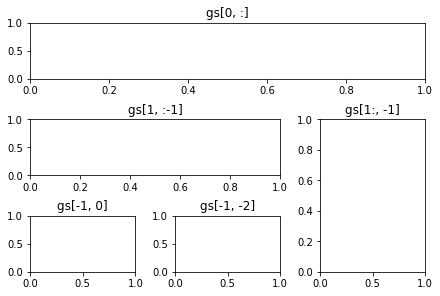

In [71]:
fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(3, 3)
f3_ax1 = fig3.add_subplot(gs[0, :])
f3_ax1.set_title('gs[0, :]')
f3_ax2 = fig3.add_subplot(gs[1, :-1])
f3_ax2.set_title('gs[1, :-1]')
f3_ax3 = fig3.add_subplot(gs[1:, -1])
f3_ax3.set_title('gs[1:, -1]')
f3_ax4 = fig3.add_subplot(gs[-1, 0])
f3_ax4.set_title('gs[-1, 0]')
f3_ax5 = fig3.add_subplot(gs[-1, -2])
f3_ax5.set_title('gs[-1, -2]')

In [ ]:
fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(2,4)
f3_ax1 = fig3.add_subplot(gs[0, 1])
f3_ax1.set_title('gs[0, :]')
f3_ax2 = fig3.add_subplot(gs[1, 2])
f3_ax2.set_title('gs[1, :-1]')
#f3_ax3 = fig3.add_subplot(gs[2, 4] + gs[6, 8])
f3_ax3.set_title('gs[1:, -1]')
f3_ax4 = fig3.add_subplot(gs[5,6])
f3_ax4.set_title('gs[-1, 0]')
f3_ax5 = fig3.add_subplot(gs[6,7])
f3_ax5.set_title('gs[-1, -2]')

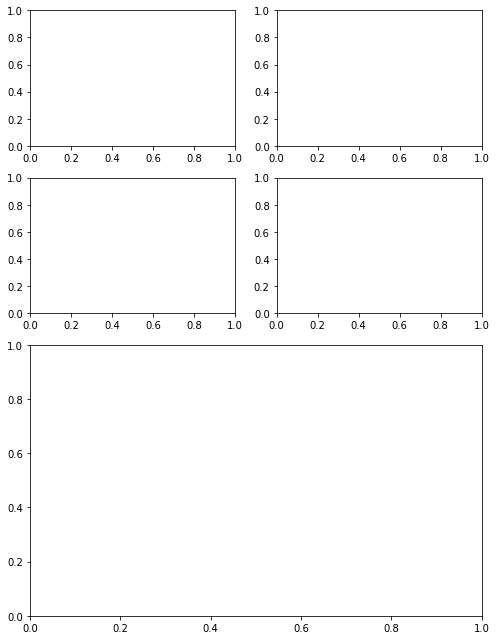